### __Import Libraries__

In [37]:
import os
import matplotlib.pyplot as plt
import cv2
import pydicom
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


### __remove warning__

In [18]:
#remove warnings
import warnings
warnings.filterwarnings('ignore')

### __Define Paths__

In [19]:
# Base dataset folder
base_dir = './Brain_Stroke_CT_Dataset'
print(os.listdir(base_dir))

# Classes
classes = ["normal", "Ischemia", "Bleeding"]

# We'll start with PNG images
png_folders = {cls: os.path.join(base_dir, cls, "png") for cls in classes}


['Bleeding', 'External_Test', 'Ischemia', 'Normal']


### __Load PNG Images and Display Samples__

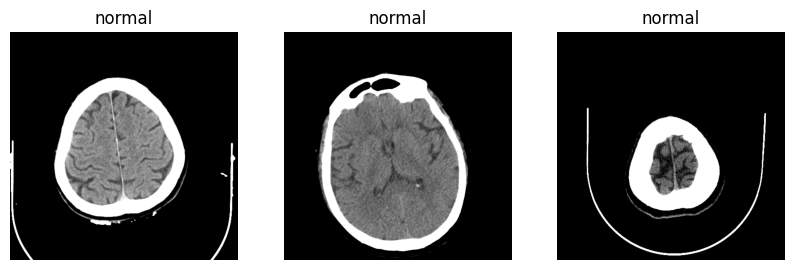

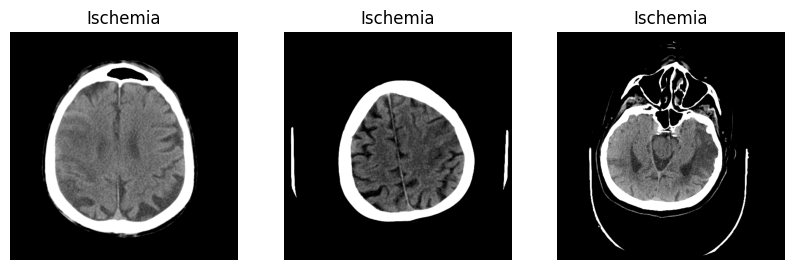

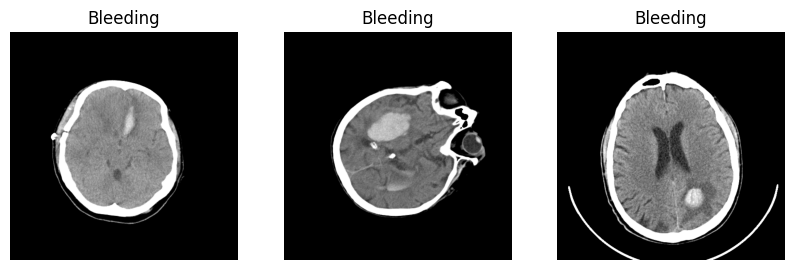

In [20]:
# Display 3 images per class
for cls in classes:
    folder = png_folders[cls]
    images = os.listdir(folder)[:3]  # first 3 images
    plt.figure(figsize=(10,3))
    
    for i, img_name in enumerate(images):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # CT images are grayscale
        plt.subplot(1, 3, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(cls)
        plt.axis('off')
    plt.show()


### __Load a DICOM Image__

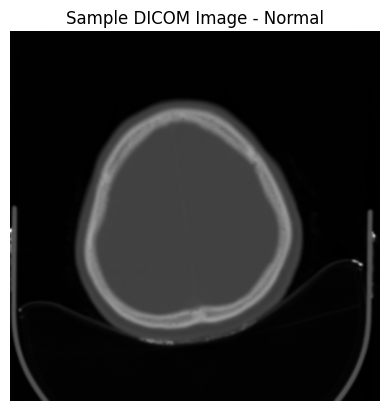

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 212
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.12.2.1107.5.1.4.92942.30000020010604300728700000817
(0002,0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002,0012) Implementation Class UID            UI: 1.3.6.1.4.1.30071.8
(0002,0013) Implementation Version Name         SH: 'fo-dicom 4.0.0'
(0002,0016) Source Application Entity Title     AE: 'TEKNOYPYZEKA'
-------------------------------------------------
(0008,0016) SOP Class UID                       UI: CT Image Storage
(0018,0050) Slice Thickness                     DS: '5'
(0028,0002) Samples per Pixel                   US: 1
(0028,0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028,0010) Rows                                US: 51

In [21]:
# Pick a DICOM file from the normal folder
dicom_file = os.path.join(base_dir, "normal", "dicom", os.listdir(os.path.join(base_dir,"normal","dicom"))[0])

# Read DICOM
dcm = pydicom.dcmread(dicom_file)
image = dcm.pixel_array

# Display
plt.imshow(image, cmap='gray')
plt.title("Sample DICOM Image - Normal")
plt.axis('off')
plt.show()

# Print some metadata
print(dcm)

### __Define preprocessing parameters__


In [22]:
IMG_SIZE = 224   # standard input size for CNN
classes = ["normal", "Ischemia", "Bleeding"]

base_dir = './Brain_Stroke_CT_Dataset'
png_folders = {cls: os.path.join(base_dir, cls, "png") for cls in classes}


### __Load, resize, and normalize all images__

In [23]:
X = []   # images
y = []   # labels

for label, cls in enumerate(classes):
    folder = png_folders[cls]
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img / 255.0     # normalize to [0,1]
            X.append(img)
            y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)

print("Dataset shape:", X.shape, y.shape)

Dataset shape: (6650, 224, 224, 1) (6650,)


### __Split into train and test sets__

In [24]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)

Train shape: (5320, 224, 224, 1)
Validation shape: (1330, 224, 224, 1)


### __Visualize a few preprocessed images__

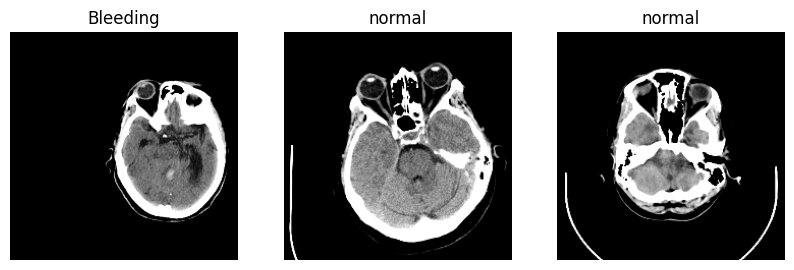

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(X_train[i].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    plt.title(classes[y_train[i]])
    plt.axis('off')
plt.show()


### __Using Keras’ ImageDataGenerator__

In [26]:
# For training data
train_datagen = ImageDataGenerator(
    rotation_range=15,      # rotate ±15 degrees
    width_shift_range=0.1,  # shift horizontally by ±10%
    height_shift_range=0.1, # shift vertically by ±10%
    zoom_range=0.1,         # zoom in/out ±10%
    horizontal_flip=True,   # randomly flip horizontally
    vertical_flip=False,    # optional: brain images usually not flipped vertically
)

# For validation data: just rescale
val_datagen = ImageDataGenerator()

### __Create augmented generators__

In [27]:
batch_size = 32

train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=batch_size
)

val_generator = val_datagen.flow(
    X_val, y_val,
    batch_size=batch_size
)


### __Visualize augmented images__

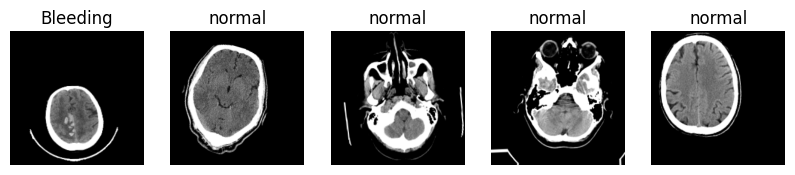

In [28]:
# Take one batch of augmented images
aug_images, aug_labels = next(train_generator)

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(aug_images[i].reshape(224,224), cmap='gray')
    plt.title(classes[aug_labels[i]])
    plt.axis('off')
plt.show()


### __Build the CNN__

In [29]:
IMG_SIZE = 224
num_classes = 3  # Normal, Ischemia, Bleeding

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # 3 classes
])

### __Compile the model__

In [30]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',  # because labels are integers
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,244,867 (84.86 MB)

 Trainable params: 22,244,867 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

### __Set training parameters__

In [31]:
epochs = 15
batch_size = 32

### __Train using the augmented data generator__

In [32]:
history = model.fit(
    train_generator,       # augmented training data
    validation_data=val_generator,  # validation data (not augmented)
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.6622 - loss: 0.8597 - val_accuracy: 0.6699 - val_loss: 0.7755
Epoch 2/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - accuracy: 0.6669 - loss: 0.8062 - val_accuracy: 0.6774 - val_loss: 0.7361
Epoch 3/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.6726 - loss: 0.7893 - val_accuracy: 0.6714 - val_loss: 0.7359
Epoch 4/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.6776 - loss: 0.7691 - val_accuracy: 0.7150 - val_loss: 0.7032
Epoch 5/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 162s 969ms/step - accuracy: 0.6910 - loss: 0.7562 - val_accuracy: 0.7203 - val_loss: 0.6801
Epoch 6/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 120s 717ms/step - accuracy: 0.7053 - loss: 0.7317 - val_accuracy: 0.6925 - val_loss: 0.6905
Epoch 7/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 120s 716ms/step - accuracy: 0.7135 - loss: 0.7104 - val_accuracy: 0.7135 - val_loss: 0.7030
Epoch 8/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 119s 712ms/step - accuracy: 0.7227 - loss: 0.693

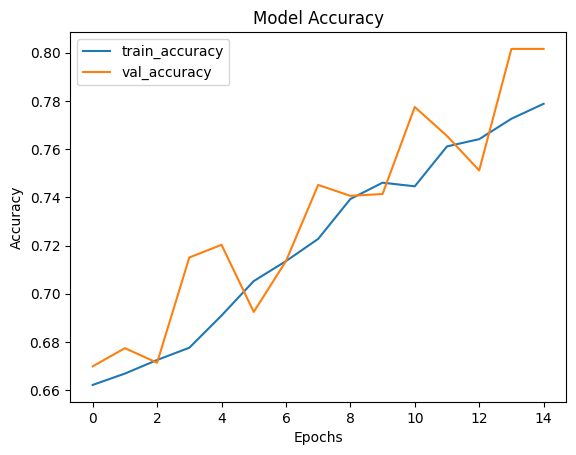

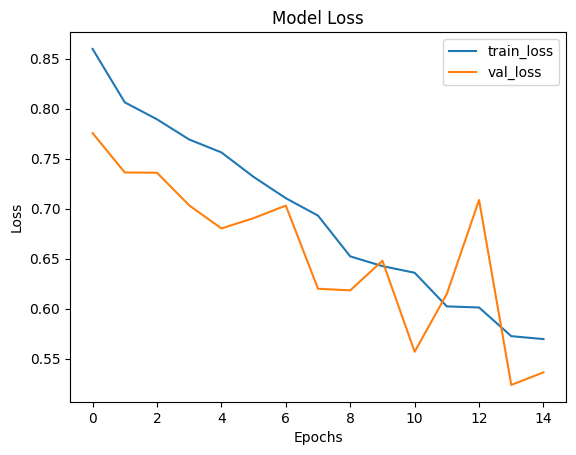

In [33]:
# Accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [34]:
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc*100:.2f}%")
    

42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 172ms/step - accuracy: 0.8015 - loss: 0.5362
Validation Accuracy: 80.15%


### __Load the External Test Data__

In [38]:
# Paths
base_dir = "./Brain_Stroke_CT_Dataset"
test_dir = os.path.join(base_dir, "External_Test", "PNG")
labels_path = os.path.join(base_dir, "External_Test", "labels.csv")

# Load CSV
labels_df = pd.read_csv(labels_path)

X_test = []
y_test = []

for _, row in labels_df.iterrows():
    img_filename = f"{row['image_id']}.png"
    img_path = os.path.join(test_dir, img_filename)
    if os.path.exists(img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (224, 224))
        img = img / 255.0
        X_test.append(img)
        y_test.append(row['Stroke'])

X_test = np.array(X_test).reshape(-1, 224, 224, 1)
y_test = np.array(y_test)

print("Test set shape:", X_test.shape, y_test.shape)

Test set shape: (200, 224, 224, 1) (200,)


### __Evaluate on External Test Set__

In [39]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"External Test Accuracy: {test_acc*100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.7000 - loss: 0.7974
External Test Accuracy: 70.00%


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step


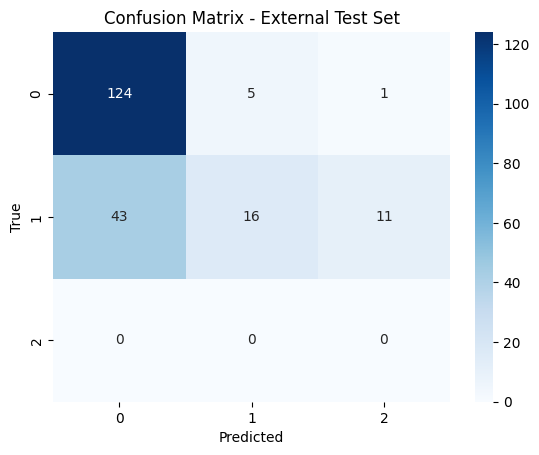

              precision    recall  f1-score   support

           0       0.74      0.95      0.84       130
           1       0.76      0.23      0.35        70
           2       0.00      0.00      0.00         0

    accuracy                           0.70       200
   macro avg       0.50      0.39      0.40       200
weighted avg       0.75      0.70      0.67       200



In [40]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = np.argmax(model.predict(X_test), axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - External Test Set')
plt.show()

# Classification report
print(classification_report(y_test, y_pred))

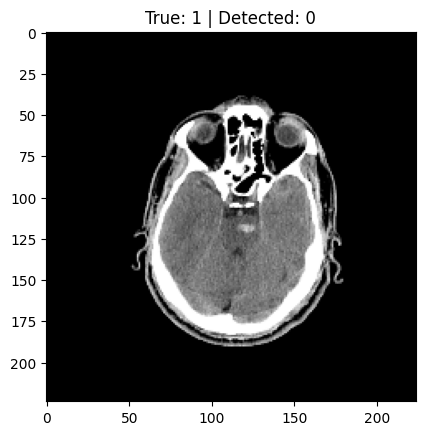

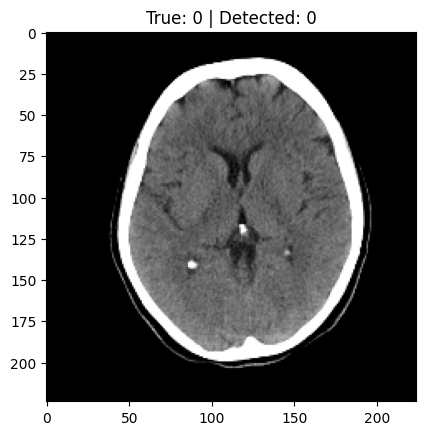

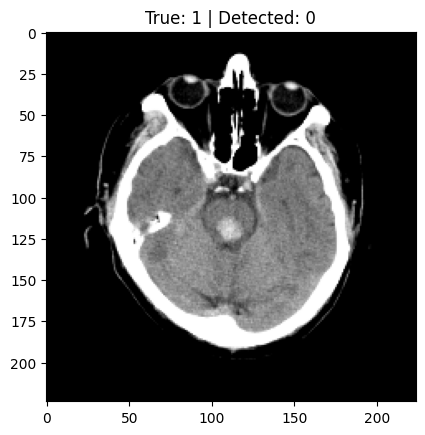

In [48]:
import random
indices = random.sample(range(len(X_test)), 3)
for i in indices:
    plt.imshow(X_test[i].reshape(224,224), cmap='gray')
    plt.title(f"True: {y_test[i]} | Detected: {y_pred[i]}")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


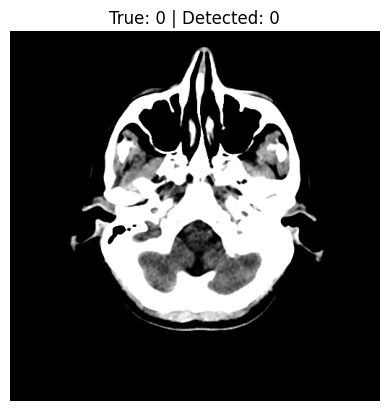

✅ Model detected correctly!
Label meaning — 0: Normal | 1: Stroke


In [50]:
# Choose an image ID you want to test (make sure it exists in labels.csv)
image_id = 10319

# Find the true label from labels.csv
true_label = labels_df.loc[labels_df["image_id"] == image_id, "Stroke"].values[0]

# Load and preprocess the image
img_path = f"Brain_Stroke_CT_Dataset/External_Test/PNG/{image_id}.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img_resized = cv2.resize(img, (224, 224)) / 255.0
img_input = np.expand_dims(img_resized, axis=(0, -1))  # (1,224,224,1)

# Predict using the trained model
prediction = model.predict(img_input)

# If model has 3 output classes (softmax)
if prediction.shape[1] == 3:
    pred_class = np.argmax(prediction, axis=1)[0]
else:
    pred_class = (prediction > 0.5).astype("int32")[0][0]

# Show image and results
plt.imshow(img, cmap="gray")
plt.title(f"True: {true_label} | Detected: {pred_class}")
plt.axis("off")
plt.show()

# Print readable result
if pred_class == true_label:
    print("✅ Model detected correctly!")
else:
    print("❌ Model prediction is incorrect!")

# Optional: show label meaning
print("Label meaning — 0: Normal | 1: Stroke")
